# Support Vector Machine (SVM)

## Libraries Loading

In [1]:
library(tidyverse)
library(ggplot2)
library(e1071)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data loading

In [2]:
data <- read_csv('../00_data/Social_Network_Ads.csv')
head(data)

Rows: 400 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): Age, EstimatedSalary, Purchased

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,EstimatedSalary,Purchased
<dbl>,<dbl>,<dbl>
19,19000,0
35,20000,0
26,43000,0
27,57000,0
19,76000,0
27,58000,0


In [3]:
# data structure
glimpse(data)

Rows: 400
Columns: 3
$ Age             <dbl> 19, 35, 26, 27, 19, 27, 27, 32, 25, 35, 26, 26, 20, 32…
$ EstimatedSalary <dbl> 19000, 20000, 43000, 57000, 76000, 58000, 84000, 15000…
$ Purchased       <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, …


In [4]:
data <- data |>
        mutate(Purchased = factor(data$Purchased, levels = c(0, 1), labels = c('No', 'Yes')))

In [5]:
glimpse(data)

Rows: 400
Columns: 3
$ Age             <dbl> 19, 35, 26, 27, 19, 27, 27, 32, 25, 35, 26, 26, 20, 32…
$ EstimatedSalary <dbl> 19000, 20000, 43000, 57000, 76000, 58000, 84000, 15000…
$ Purchased       <fct> No, No, No, No, No, No, No, Yes, No, No, No, No, No, N…


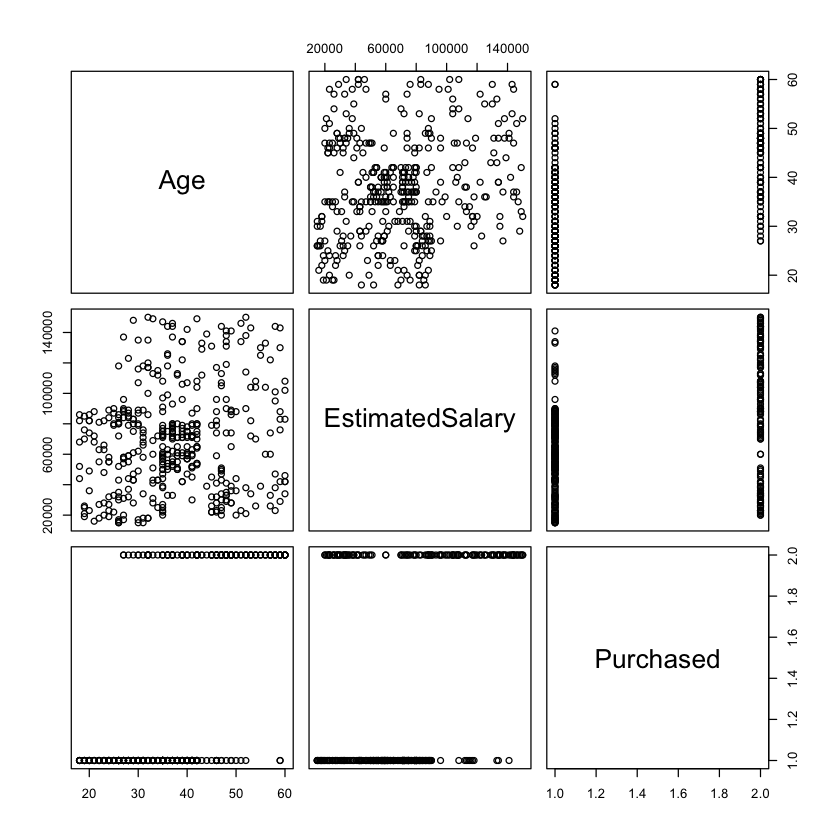

In [6]:
pairs(data)

# Splitting data into training and test set

In [7]:
set.seed(123)

train_data <- data |> slice_sample(prop = 0.75)
test_data <- data |> anti_join(train_data)

Joining with `by = join_by(Age, EstimatedSalary, Purchased)`


## Feature scaling

In [8]:
train_data[-3] <- scale(train_data[, -3])
test_data[-3] <- scale(test_data[, -3])

## Fit the model on training set

In [9]:
set.seed(0)
fit <- svm(Purchased ~ .,
           data = train_data,
           kernel  = 'linear',
           type = 'C-classification')
summary(fit)


Call:
svm(formula = Purchased ~ ., data = train_data, kernel = "linear", 
    type = "C-classification")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  116

 ( 58 58 )


Number of Classes:  2 

Levels: 
 No Yes




## Predict on test set

In [10]:
y_pred <- predict(fit, newdata = test_data[-3])
y_pred

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
 No  No Yes  No  No  No  No  No  No  No  No  No  No  No  No  No Yes  No  No  No 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
 No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No  No 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
 No Yes  No  No  No  No  No  No  No  No  No Yes Yes Yes Yes  No Yes Yes Yes Yes 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
 No  No Yes Yes  No Yes Yes Yes Yes  No  No  No Yes  No Yes  No Yes Yes Yes Yes 
 81  82  83  84 
Yes Yes  No Yes 
Levels: No Yes

## Evaluation the model

### Confusion Matrix

In [11]:
cm <- table(test_data$Purchased, y_pred)
cm

     y_pred
      No Yes
  No  48   5
  Yes 10  21

**Interpretation:**
$$
\begin{bmatrix}
True Negative & False Positive\\
False Negative & True Positive
\end{bmatrix}
$$

### Accuracy Score

In [12]:
accuracy <- mean(test_data$Purchased == y_pred)
print(paste0('Accuracy :', round(accuracy*100, 2), "%"))

[1] "Accuracy :82.14%"


## Viz the results

In [13]:
svm_pred_boundary <- function(df_train, df_test, name){
    X1 <- seq(min(df_test$Age) - 1, max(df_test$Age) + 1, length.out = 200)
    X2 <- seq(min(df_test$EstimatedSalary) - 1, max(df_test$EstimatedSalary) + 1, length.out = 200)
    grid <- expand.grid(X1, X2)
    colnames(grid) <- c('Age', 'EstimatedSalary')
    grid$Prediction <- predict(fit, newdata = grid)
    
    print(ggplot() +
        geom_tile(data=grid, aes(x = Age, y = EstimatedSalary, fill = as.factor(Prediction)), alpha=0.4) +
        geom_point(df_test, mapping=aes(x = Age, y = EstimatedSalary, colour = Purchased), size=2) +
        scale_fill_manual(values = c("red", "blue"), name = "Prediction") +
        scale_color_manual(values = c("red", "blue"), name = "Purchased") +
        labs(title = paste0("SVM (", name,")"), x = "Age", y = "Estimated Salary") +
        theme_minimal())
}

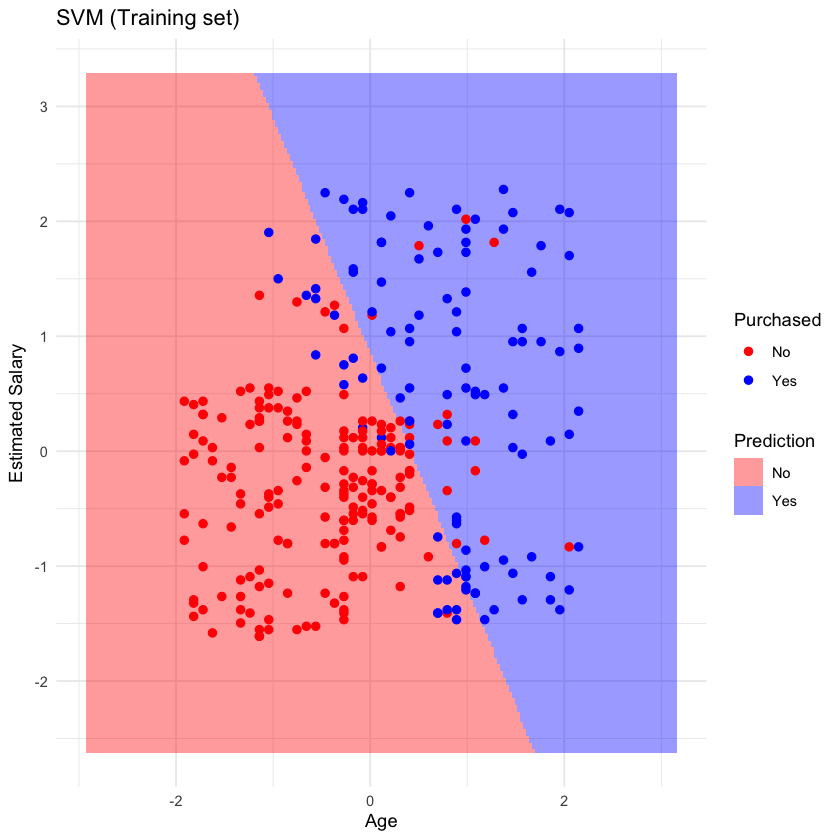

In [14]:
svm_pred_boundary(train_data, train_data, 'Training set')

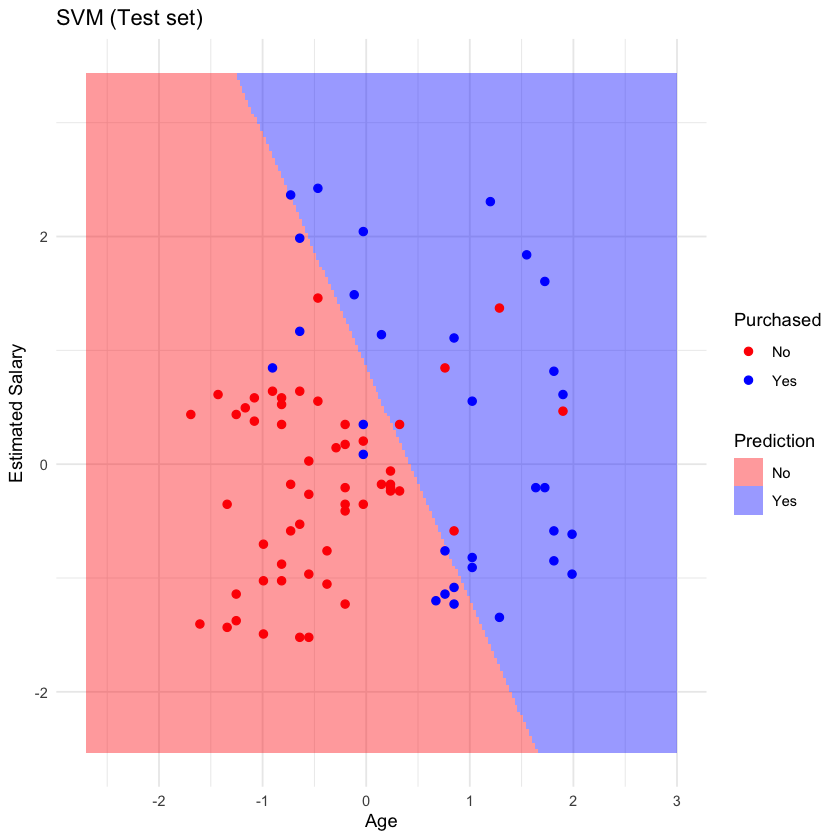

In [15]:
svm_pred_boundary(train_data, test_data, 'Test set')